In [203]:
import os

import hydra
from hydra.core.hydra_config import HydraConfig
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf

import torch
import pandas as pd
import plotnine as pn

import sys
sys.path.append("/Users/nathanielimel/uci/projects/ibsg/src")

from game.game import Game
from misc.vis import numeric_col_to_categorical


In [204]:
overrides = [
    "game.num_states=100",
    "game.num_signals=100",
    "game.meaning_dist_gamma=1",
]

# Global initialization
GlobalHydra.instance().clear() # from previous runs of notebook
hydra.initialize(version_base=None, config_path="../../conf")
config = hydra.compose(
    config_name="config",
    overrides=overrides,
)

In [205]:
g = Game.from_hydra(config)

In [206]:
def meanings_heatmap(df) -> pn.ggplot:
    return (
        pn.ggplot(df, pn.aes(x="world state", y="meaning", fill="p"))
        + pn.geom_tile()
        + pn.scale_fill_cmap(limits=[0,1])
        + pn.theme(
            axis_text_y=pn.element_blank(),
            axis_text_x=pn.element_blank(),
            axis_title_x=pn.element_text("meaning, $M$"),
            axis_title_y=pn.element_text("world state, $U$"),
        )
        + pn.ggtitle("meaning uncertainty $p(u|m)$")
    )

# construct dataframe
meanings = torch.tensor([[i] * g.num_states for i in range(g.num_states)]).flatten()
meanings
data = torch.stack([meanings, meanings, g.meaning_dists.flatten()])
data = pd.DataFrame(data.T, columns=["world state", "meaning", "p"])

# format 
data["meaning"] = data["meaning"] + 1
data["world state"] = data["world state"] + 1
data = numeric_col_to_categorical(data, "meaning")
data = numeric_col_to_categorical(data, "world state")
data

,world state,meaning,p
0,1,1,1.000000e+00
1,1,1,3.783506e-44
2,1,1,0.000000e+00
3,1,1,0.000000e+00
4,1,1,0.000000e+00
...,...,...,...
9995,100,100,0.000000e+00
9996,100,100,0.000000e+00
9997,100,100,0.000000e+00
9998,100,100,3.783506e-44


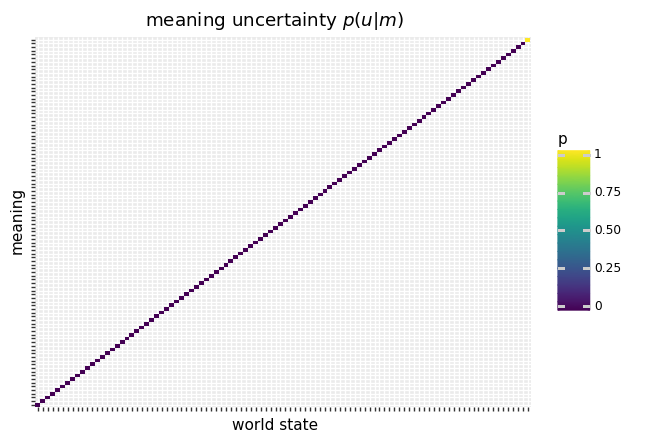

<ggplot: (376539806)>

In [207]:
# plot 
meanings_heatmap(data)

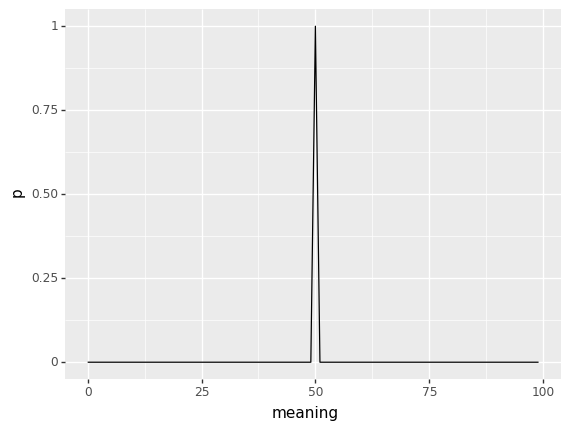

<ggplot: (392638966)>

In [208]:
# Well that's not working out well, so let's just look at a single meaning,

half = int(g.num_states / 2)
meaning = g.meaning_dists[half]
meanings = torch.Tensor(range(g.num_states))
data = pd.DataFrame(data = torch.stack([meanings, meaning]).T, columns = ["meaning", "p"])
plot = (
    pn.ggplot(data, pn.aes(x="meaning", y="p"))
    + pn.geom_line()
    + pn.ylim([0,1])
    + pn.theme(
        axis_title_x=pn.element_text("meaning, $M$"),
        axis_title_y=pn.element_text("world state, $U$"),
    )
)
plot

In [209]:
# get a scalar value: cond entropy H(U|M) of the confusion dists

# H(Y|X) = H(X,Y) - H(X)
from altk.effcomm.util import H, joint

pXY = joint(g.meaning_dists, g.prior)
pX = pXY.sum(0)
hY_X = H(pXY) - H(pX)
hY_X

0.0